# Model Analysis

You are requested to write a final notebook called ModelAnalysis.ipynb, and this is the only one that is important (meaning, is the only one that will be graded). This notebook must contain the training and evaluation of the final model: how good is it, where does it fail the most, what are the causes of its errors, what are the more important features and how they behave, etc. Also, export this notebook to HTML and place it in reports/ folder.

In [93]:
import json
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import random
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

In [94]:
con = sqlite3.connect(r"../laliga.sqlite")
# Change date format (2029 -> 1929)
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['date'] = pd.to_datetime(df[['day', 'month', 'year']]).dt.strftime('%d/%m/%Y') 

# We also change the formatting of the time to be in 24h format
df['time'] = df['time'].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)

df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df2=df.dropna(subset = "score")
df2["goal diff"] = (df2["home_goals"]  - df2["away_goals"])
df2["results"] = np.where(df2["goal diff"] > 0, "1", np.where(df2["goal diff"] < 0, "2", "X"))
df2['home_win'] = df['home_goals'] > df['away_goals']
df2.head()

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win
0,1928-1929,1,1,10/02/1929,None,Arenas Club,Athletic Madrid,2:3,2,10,1929,2.0,3.0,-1.0,2,False
1,1928-1929,1,1,10/02/1929,None,Espanyol,Real Unión,3:2,2,10,1929,3.0,2.0,1.0,1,True
2,1928-1929,1,1,10/02/1929,None,Real Madrid,Catalunya,5:0,2,10,1929,5.0,0.0,5.0,1,True
3,1928-1929,1,1,10/02/1929,None,Donostia,Athletic,1:1,2,10,1929,1.0,1.0,0.0,X,False
4,1928-1929,1,1,12/02/1929,None,Racing,Barcelona,0:2,2,12,1929,0.0,2.0,-2.0,2,False


In [95]:
def parse_seasons(value):
    if value == "all":
        return "all"
    seasons = []
    for chunk in value.split(","):
        if ":" in chunk:
            try:
                start, end = map(int, chunk.split(":"))
                assert start < end
            except Exception:
                print("error")
            for i in range(start, end):
                seasons.append(f"{i}-{i+1}")
        else:
            try:
                start, end = map(int, chunk.split("-"))
                assert start == end - 1
            except Exception:
                print("error")
            seasons.append(chunk)
    return seasons

In [96]:
def avg_ranking_goals(team, df, gen_dic, res_dic):
    ranking = []
    net_goals = []
    seasons = df["season"].unique()
    for season in seasons:
        try:
            ranking.append(gen_dic["seasonal_data"][season][team][0])
        except KeyError:
            pass
        try:
            net_goals.append(gen_dic["seasonal_data"][season][team][1])
        except KeyError:
            pass
    avg_ranking = round(np.average(ranking), 3)
    avg_net_goals = round(np.average(net_goals), 3)
    res_dic[team] = [avg_ranking, avg_net_goals]

## Training Data

In [97]:
train_seasons = parse_seasons("2010:2020")
train_df = df2[df2["season"].isin(train_seasons)]
train_df[["home_goals", "away_goals"]] = train_df["score"].str.split(":", expand=True).astype(float)
train_df["goal diff"] = (train_df["home_goals"] - train_df["away_goals"])
train_df["results"] = np.where(train_df["goal diff"] > 0, "1", np.where(train_df["goal diff"] < 0, "2", "X"))

dic_import_data = {}
with open("../feature_data.json", "r") as infile:
    dic_import_data = json.load(infile)

dic_feature_data = {}

train_df["rank_diff"] = 0
train_df["goal_diff"] = 0

for index, row in train_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    if home_team not in dic_feature_data:
        avg_ranking_goals(home_team, train_df, dic_import_data, dic_feature_data)
    if away_team not in dic_feature_data:
        avg_ranking_goals(away_team, train_df, dic_import_data, dic_feature_data)
    train_df.loc[row.name, "rank_diff"] = dic_feature_data[home_team][0] - dic_feature_data[away_team][0]
    train_df.loc[row.name, "goal_diff"] = dic_feature_data[home_team][1] - dic_feature_data[away_team][1]

with open("train_features.json", "w") as outfile:
    json.dump(dic_feature_data, outfile)

col_names = ["rank_diff", "goal_diff"]
x_train = train_df[col_names]
y_train = train_df.results

# Testing data

In [98]:
test_seasons = parse_seasons("2021:2022")
test_df = df2[df2["season"].isin(test_seasons)]

test_df[["home_goals", "away_goals"]] = test_df["score"].str.split(":", expand=True).astype(float)
test_df["goal diff"] = (test_df["home_goals"] - test_df["away_goals"])
test_df["results"] = np.where(test_df["goal diff"] > 0, "1", np.where(test_df["goal diff"] < 0, "2", "X"))

test_df["rank_diff"] = 0
test_df["goal_diff"] = 0


with open("train_features.json", "r") as infile:
    dic_feature_data = json.load(infile)

for index, row in test_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    if home_team not in dic_feature_data:
        avg_rank_home = 30
        avg_goals_home = -10
    else:
        avg_rank_home = dic_feature_data[home_team][0]
        avg_goals_home = dic_feature_data[home_team][1]
    
    if away_team not in dic_feature_data:
        avg_rank_away = 30
        avg_goals_away = -10
    else:
        avg_rank_away = dic_feature_data[away_team][0]
        avg_goals_away = dic_feature_data[away_team][1]

    test_df.loc[row.name, "rank_diff"] = avg_rank_home - avg_rank_away
    test_df.loc[row.name, "goal_diff"] = avg_goals_home - avg_goals_away

In [103]:
try_train_df = train_df.copy(deep = True)
for index, row in try_train_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    try_train_df.loc[row.name, "home_team"] = dic_import_data["teams_codif"][home_team]
    try_train_df.loc[row.name, "away_team"] = dic_import_data["teams_codif"][away_team]

col_names = ["rank_diff", "goal_diff", "home_team", "away_team"]
x_train = try_train_df[col_names].dropna()
y_train = try_train_df.results

try_test_df = test_df.copy(deep = True)
for index, row in try_test_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    try_test_df.loc[row.name, "home_team"] = dic_import_data["teams_codif"][home_team]
    try_test_df.loc[row.name, "away_team"] = dic_import_data["teams_codif"][away_team]

col_names = ["rank_diff", "goal_diff", "home_team", "away_team"]
x_test = try_test_df[col_names]
y_test = try_test_df.results

In [104]:
model_results = {}
for weight in ["uniform", "distance"]:
    for algorithm in ["auto", "ball_tree", "kd_tree", "brute"]:
        for n_neighbors in [5,6,7,8,9,10,11,12,13,14,15]:
            # we create an instance of Neighbours Classifier and fit the data.
            clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weight, algorithm=algorithm)
            clf.fit(x_train, y_train)
            model_results[f"{weight}, {algorithm}, {n_neighbors}"] = clf.score(x_test, y_test)

sorted_models = dict(sorted(model_results.items(), key=lambda item: item[1], reverse = True))
print(sorted_models)

{'uniform, brute, 6': 0.5645161290322581, 'uniform, auto, 7': 0.532258064516129, 'uniform, ball_tree, 13': 0.532258064516129, 'uniform, kd_tree, 7': 0.532258064516129, 'uniform, brute, 5': 0.532258064516129, 'uniform, brute, 7': 0.532258064516129, 'uniform, brute, 13': 0.532258064516129, 'distance, auto, 7': 0.532258064516129, 'distance, auto, 8': 0.532258064516129, 'distance, ball_tree, 8': 0.532258064516129, 'distance, ball_tree, 9': 0.532258064516129, 'distance, ball_tree, 10': 0.532258064516129, 'distance, kd_tree, 7': 0.532258064516129, 'distance, kd_tree, 8': 0.532258064516129, 'distance, brute, 6': 0.532258064516129, 'distance, brute, 7': 0.532258064516129, 'distance, brute, 8': 0.532258064516129, 'uniform, auto, 6': 0.5161290322580645, 'uniform, auto, 13': 0.5161290322580645, 'uniform, ball_tree, 6': 0.5161290322580645, 'uniform, ball_tree, 7': 0.5161290322580645, 'uniform, ball_tree, 12': 0.5161290322580645, 'uniform, kd_tree, 6': 0.5161290322580645, 'uniform, kd_tree, 13': 0.

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

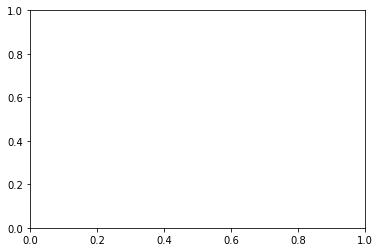

In [106]:
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = [ "darkblue", "darkorange", "c"]

n_neighbors = 6
weights = "uniform"
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm="brute")
clf.fit(x_train, y_train)
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="rank_diff",
    ylabel="goal_diff",
    shading="auto",
)

# Plot also the training points
sns.scatterplot(
    x=x_train["rank_diff"],
    y=x_train["goal_diff"],
    hue=y_train,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title(
    "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
)

Precision: 0.5645161290322581


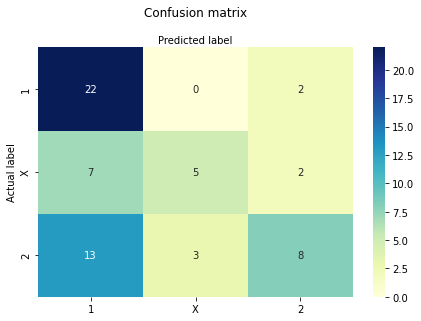

In [102]:
print(f"Precision: {clf.score(x_test, y_test)}")

y_pred = clf.predict(x_test)

from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.xticks([0.5,1.5,2.5], labels=["1", "X", "2"])
plt.yticks([0.5,1.5,2.5], labels=["1", "X", "2"])
plt.Text(0.5,257.44,'Predicted label');

In [ ]:
def Accuracy_table(Weight):
    
    acc_df = accuracy_df[accuracy_df.Weight == Weight]
    
    table = pd.crosstab(accuracy_df.Algorithm, accuracy_df.Neighbors, rownames=['Algorithms'], colnames=['Number of neighbors'], values=accuracy_df.accuracy, aggfunc='first')
    
    return table
Accuracy_table('uniform,')

NameError: name 'accuracy_df' is not defined

In [ ]:
def Accuracy_table(Weight):
    
    acc_df = accuracy_df[accuracy_df.Weight == Weight]
    table = pd.crosstab(accuracy_df.Algorithm, accuracy_df.Neighbors, rownames=['Algorithms'], colnames=['Number of neighbors'], values=accuracy_df.accuracy, aggfunc='first')
    
    return table
Accuracy_table('distance,')

Number of neighbors,10,15,20,30,40,5,50
Algorithms,,,,,,,
"auto,",0.548387,0.572581,0.572581,0.58871,0.572581,0.532258,0.580645
"ball_tree,",0.548387,0.572581,0.572581,0.58871,0.580645,0.524194,0.580645
"brute,",0.556452,0.564516,0.572581,0.58871,0.580645,0.532258,0.580645
"kd_tree,",0.548387,0.572581,0.572581,0.58871,0.572581,0.532258,0.580645
